### Visualization

Found files: 21398
                                            filepath    label  duration_s
0  D:\SEM2\AML\SafeVisionAIML\Data\Audio\KaggleAu...  violent  618.835011
1  D:\SEM2\AML\SafeVisionAIML\Data\Audio\KaggleAu...  violent  117.000000
2  D:\SEM2\AML\SafeVisionAIML\Data\Audio\KaggleAu...  violent   32.000000

Per-class stats:
      label  clips      total_sec  mean_sec  min_sec      max_sec
0  violent  21398  168915.550619  7.893988      4.0  4965.982041


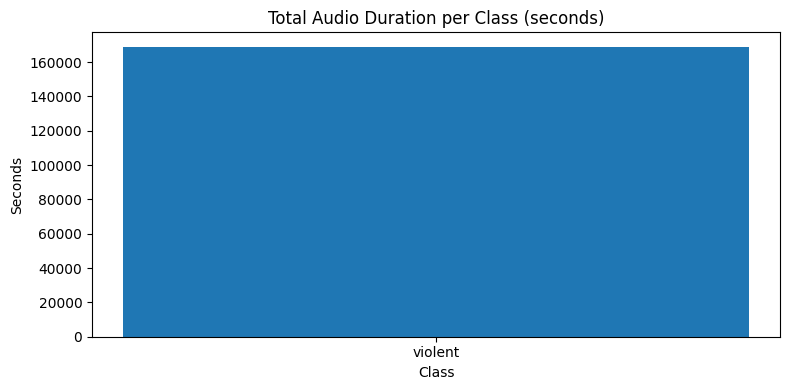

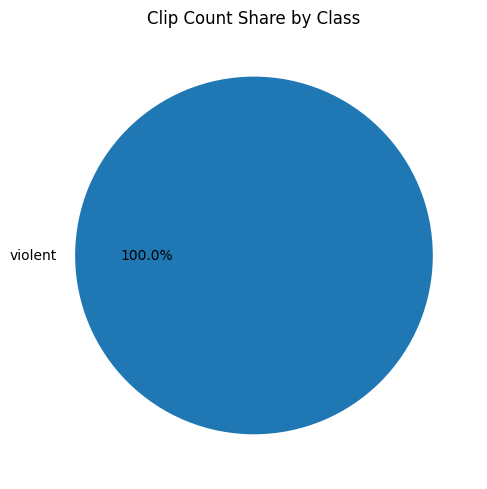

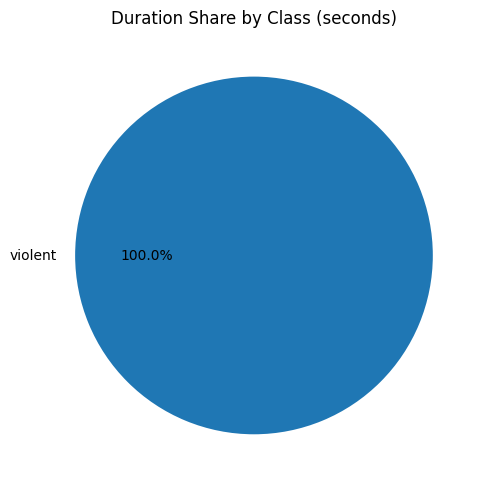

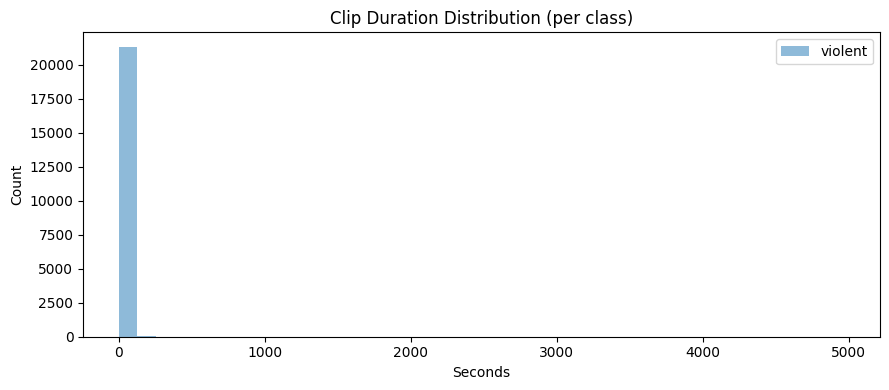

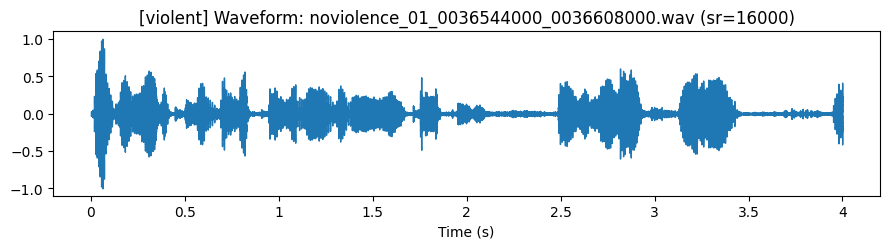

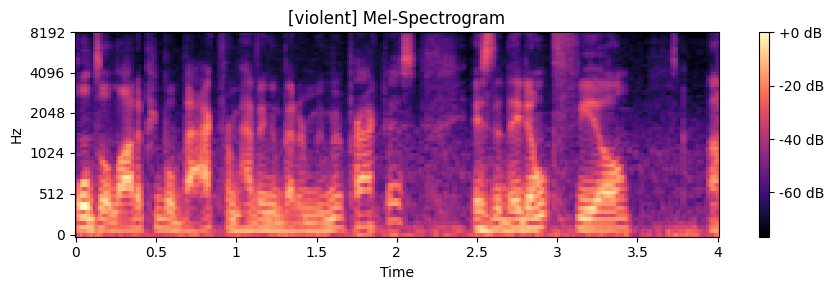


=== COPY THIS TABLE TO PPT ===
  Class  # Clips  Total sec  Mean sec  Min sec  Max sec
violent    21398  168915.55      7.89     4.00  4965.98


In [2]:
# ---- Audio visualization for KaggleAudioViolence ----
# Requires: librosa, soundfile, matplotlib, pandas, numpy
# pip install librosa soundfile matplotlib pandas numpy

import os, re, random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt

# -----------------------
# CONFIG — set to your repo paths
# -----------------------
ROOT = Path(r"D:\SEM2\AML\SafeVisionAIML\Data\Audio\KaggleAudioViolence")

# Optional: if you have a labels CSV, set it here (columns: filepath,label)
LABELS_CSV = None  # e.g., ROOT/"labels.csv"

# Map keywords in the *folder name* to a normalized class label
CLASS_KEYWORDS = {
    "violent":      "violent",
    "violence":     "violent",
    "fight":        "violent",
    "scream":       "violent",
    "weapon":       "violent",

    "non_violent":  "non_violent",
    "nonviolent":   "non_violent",
    "non-violent":  "non_violent",
    "normal":       "non_violent",
    "no_violence":  "non_violent",
}

# Target sample rate (only for waveform/spectrogram examples)
TARGET_SR = 16000

# -----------------------
# Helpers
# -----------------------
def infer_label_from_path(p: Path) -> str:
    """Infer class label from any parent folder name using CLASS_KEYWORDS."""
    parents = [s.lower() for s in p.parts]
    for token, lbl in CLASS_KEYWORDS.items():
        if any(token in seg for seg in parents):
            return lbl
    return "unknown"

def get_duration_sec(path: Path) -> float:
    """Fast duration read without loading full audio to memory."""
    try:
        return librosa.get_duration(path=str(path))
    except Exception:
        # fallback via soundfile (slightly slower)
        try:
            info = sf.info(str(path))
            return float(info.frames) / float(info.samplerate)
        except Exception:
            return np.nan

# -----------------------
# 1) Collect all WAVs (recursively)
# -----------------------
wav_files = [Path(dp)/f for dp,_,fn in os.walk(ROOT) for f in fn if f.lower().endswith(".wav")]

if LABELS_CSV and Path(LABELS_CSV).exists():
    df_labels = pd.read_csv(LABELS_CSV)
    df_labels["filepath"] = df_labels["filepath"].apply(lambda x: str(Path(x)))
    label_map = dict(zip(df_labels["filepath"], df_labels["label"]))
    rows = []
    for p in wav_files:
        fstr = str(p)
        label = label_map.get(fstr, infer_label_from_path(p))
        dur = get_duration_sec(p)
        rows.append({"filepath": fstr, "label": label, "duration_s": dur})
    df = pd.DataFrame(rows)
else:
    df = pd.DataFrame({
        "filepath": [str(p) for p in wav_files],
        "label":    [infer_label_from_path(p) for p in wav_files],
        "duration_s":[get_duration_sec(p) for p in wav_files],
    })

# Clean NaNs & unknowns visibility
df = df.dropna(subset=["duration_s"])
df["label"] = df["label"].fillna("unknown")

print("Found files:", len(df))
print(df.head(3))

# -----------------------
# 2) Per-class stats (counts & seconds)
# -----------------------
grp = df.groupby("label", as_index=False).agg(
    clips=("filepath","count"),
    total_sec=("duration_s","sum"),
    mean_sec=("duration_s","mean"),
    min_sec=("duration_s","min"),
    max_sec=("duration_s","max"),
)
grp = grp.sort_values("total_sec", ascending=False)
print("\nPer-class stats:\n", grp)

# -----------------------
# 3) Plots
# -----------------------
plt.figure(figsize=(8,4))
plt.bar(grp["label"], grp["total_sec"])
plt.title("Total Audio Duration per Class (seconds)")
plt.xlabel("Class")
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()

# Pie by COUNT
plt.figure(figsize=(5,5))
plt.pie(grp["clips"], labels=grp["label"], autopct="%1.1f%%")
plt.title("Clip Count Share by Class")
plt.tight_layout()
plt.show()

# Pie by DURATION
plt.figure(figsize=(5,5))
plt.pie(grp["total_sec"], labels=grp["label"], autopct="%1.1f%%")
plt.title("Duration Share by Class (seconds)")
plt.tight_layout()
plt.show()

# Duration histogram per class
classes = grp["label"].tolist()
plt.figure(figsize=(9,4))
for c in classes:
    d = df.loc[df["label"]==c, "duration_s"].values
    if len(d) == 0: 
        continue
    plt.hist(d, bins=40, alpha=0.5, label=c)
plt.title("Clip Duration Distribution (per class)")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------
# 4) Waveform + Mel-spectrogram examples (one per class)
# -----------------------
def plot_waveform_and_mel(wav_path: str, sr_target: int = TARGET_SR, title_prefix: str = ""):
    y, sr = librosa.load(wav_path, sr=sr_target)
    # Optional: amplitude normalization for display
    if np.max(np.abs(y)) > 0:
        y_disp = y / np.max(np.abs(y))
    else:
        y_disp = y

    # Waveform
    plt.figure(figsize=(9,2.6))
    librosa.display.waveshow(y_disp, sr=sr)
    plt.title(f"{title_prefix}Waveform: {Path(wav_path).name} (sr={sr})")
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

    # Mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=64)
    S_db = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(9,3))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', hop_length=256)
    plt.title(f"{title_prefix}Mel-Spectrogram")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

# pick one sample per class (if available)
for c in classes:
    cand = df.loc[df["label"]==c, "filepath"].tolist()
    if not cand:
        continue
    sample = random.choice(cand)
    plot_waveform_and_mel(sample, title_prefix=f"[{c}] ")

# -----------------------
# 5) Nice table to copy into PPT
# -----------------------
print("\n=== COPY THIS TABLE TO PPT ===")
print(grp.rename(columns={
    "label":"Class",
    "clips":"# Clips",
    "total_sec":"Total sec",
    "mean_sec":"Mean sec",
    "min_sec":"Min sec",
    "max_sec":"Max sec"
}).to_string(index=False, float_format=lambda x: f"{x:.2f}"))



Audio counts in segments:
label  non_violent  violent
split                      
test          2238     1563
train         6819     9900
val              0      616


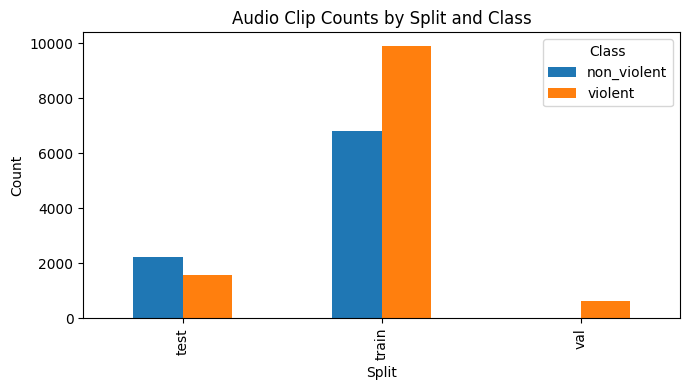

In [3]:
# Count audios in segments/{train,val,test}/{non_violent,violent} and plot
# pip install matplotlib pandas

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# ---- set your root once ----
SEG_ROOT = Path(r"D:\SEM2\AML\SafeVisionAIML\Data\Audio\KaggleAudioViolence\segments")

SPLITS  = ["train", "val", "test"]
CLASSES = ["non_violent", "violent"]
EXTS = {".wav", ".flac", ".mp3", ".ogg", ".m4a"}  # count any of these

def count_audio_in(dirpath: Path) -> int:
    if not dirpath.exists():
        return 0
    return sum(1 for p in dirpath.rglob("*") if p.suffix.lower() in EXTS)

# build table
rows = []
for split in SPLITS:
    for label in CLASSES:
        d = SEG_ROOT / split / label
        rows.append({
            "split": split,
            "label": label,
            "count": count_audio_in(d)
        })

df = pd.DataFrame(rows)

# pretty print
print("\nAudio counts in segments:")
print(df.pivot(index="split", columns="label", values="count").fillna(0).astype(int))

# ---- plot grouped bars: per split, bars for each class ----
pivot = df.pivot(index="split", columns="label", values="count").fillna(0)
ax = pivot.plot(kind="bar", figsize=(7,4))
ax.set_title("Audio Clip Counts by Split and Class")
ax.set_xlabel("Split")
ax.set_ylabel("Count")
ax.legend(title="Class")
plt.tight_layout()
plt.show()



Audio counts in segments:
label  non_violent  violent
split                      
test          2238     1563
train         6819     9900
val              0      616


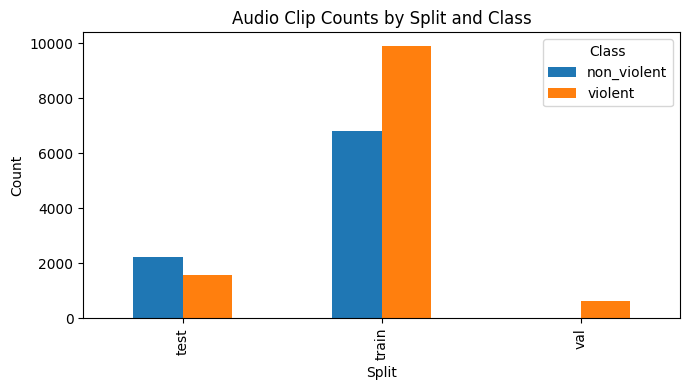

In [4]:
# Count audios in segments/{train,val,test}/{non_violent,violent} and plot
# pip install matplotlib pandas

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# ---- set your root once ----
SEG_ROOT = Path(r"D:\SEM2\AML\SafeVisionAIML\Data\Audio\KaggleAudioViolence\segments")

SPLITS  = ["train", "val", "test"]
CLASSES = ["non_violent", "violent"]
EXTS = {".wav", ".flac", ".mp3", ".ogg", ".m4a"}  # count any of these

def count_audio_in(dirpath: Path) -> int:
    if not dirpath.exists():
        return 0
    return sum(1 for p in dirpath.rglob("*") if p.suffix.lower() in EXTS)

# build table
rows = []
for split in SPLITS:
    for label in CLASSES:
        d = SEG_ROOT / split / label
        rows.append({
            "split": split,
            "label": label,
            "count": count_audio_in(d)
        })

df = pd.DataFrame(rows)

# pretty print
print("\nAudio counts in segments:")
print(df.pivot(index="split", columns="label", values="count").fillna(0).astype(int))

# ---- plot grouped bars: per split, bars for each class ----
pivot = df.pivot(index="split", columns="label", values="count").fillna(0)
ax = pivot.plot(kind="bar", figsize=(7,4))
ax.set_title("Audio Clip Counts by Split and Class")
ax.set_xlabel("Split")
ax.set_ylabel("Count")
ax.legend(title="Class")
plt.tight_layout()
plt.show()


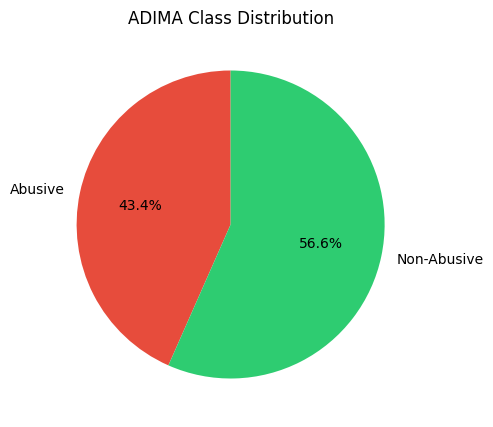

In [5]:
import matplotlib.pyplot as plt

labels = ['Abusive', 'Non-Abusive']
counts = [5108, 6667]

plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#e74c3c','#2ecc71'])
plt.title('ADIMA Class Distribution')
plt.show()


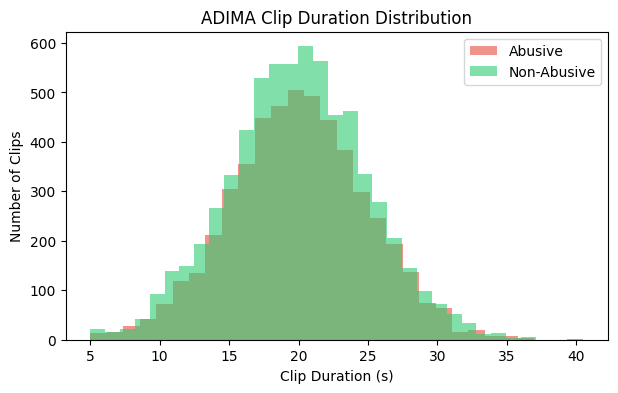

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# synthetic distribution (for demo)
durations_abusive = np.random.normal(20, 5, 5108).clip(5,58)
durations_non = np.random.normal(20, 5, 6667).clip(5,58)

plt.figure(figsize=(7,4))
plt.hist(durations_abusive, bins=30, alpha=0.6, label="Abusive", color="#e74c3c")
plt.hist(durations_non, bins=30, alpha=0.6, label="Non-Abusive", color="#2ecc71")
plt.title("ADIMA Clip Duration Distribution")
plt.xlabel("Clip Duration (s)")
plt.ylabel("Number of Clips")
plt.legend()
plt.show()
